## Setting

In [1]:
# drive mount & setting for TaPR package
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install '/content/drive/My Drive/data/eTaPR-1.12-py3-none-any.whl'

Processing ./drive/My Drive/data/eTaPR-1.12-py3-none-any.whl


In [3]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

HOME = '/content/drive/My Drive'

In [4]:
# functions
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets]) # added ignore_index

In [5]:
# data loading
TRAIN_DATASET = sorted([x for x in Path(HOME +"/data/training/").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path(HOME + "/data/testing/").glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path(HOME + "/data/validation/").glob("*.csv")])

TRAIN_DATASET, TEST_DATASET, VALIDATION_DATASET

([PosixPath('/content/drive/My Drive/data/training/train1.csv'),
  PosixPath('/content/drive/My Drive/data/training/train2.csv'),
  PosixPath('/content/drive/My Drive/data/training/train3.csv')],
 [PosixPath('/content/drive/My Drive/data/testing/test1.csv'),
  PosixPath('/content/drive/My Drive/data/testing/test2.csv'),
  PosixPath('/content/drive/My Drive/data/testing/test3.csv'),
  PosixPath('/content/drive/My Drive/data/testing/test4.csv')],
 [PosixPath('/content/drive/My Drive/data/validation/validation.csv')])

In [6]:
# data type to pandas DataFrame
TRAIN_DATASET = dataframe_from_csvs(TRAIN_DATASET)
TEST_DATASET = dataframe_from_csvs(TEST_DATASET)
VALIDATION_DATASET = dataframe_from_csvs(VALIDATION_DATASET)

### FE

In [7]:
# seasonality
def season(df):
  sdf = df.copy()
  sdf['hour'] = sdf['time'].apply(lambda t : dateutil.parser.parse(t).hour)
  sdf['min'] = sdf['time'].apply(lambda t : dateutil.parser.parse(t).minute)
  sdf['weekday'] = sdf['time'].apply(lambda t : dateutil.parser.parse(t).weekday())
  sdf['sec'] = sdf['time'].apply(lambda t : dateutil.parser.parse(t).second)
  return sdf

TRAIN_DATASET = season(TRAIN_DATASET)
VALIDATION_DATASET = season(VALIDATION_DATASET)
TEST_DATASET = season(TEST_DATASET)
# TRAIN_DATASET.to_csv('s_train', index = False)
# VALIDATION_DATASET.to_csv('s_val', index = False)
# TEST_DATASET.to_csv('s_test', index = False)

### Scaling

In [10]:
# normalizing
STATE = TRAIN_DATASET.columns.drop(['time'])
SEASONALITY = ['min', 'hour', 'sec', 'weekday']
TAG_MIN, TAG_MAX = TRAIN_DATASET[STATE].min(), TRAIN_DATASET[STATE].max()

def normalize(df):
  ndf = df.copy()
  for c in df.columns:
      if TAG_MIN[c] == TAG_MAX[c]:
          ndf[c] = df[c] - TAG_MIN[c]
      else:
          ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
  return ndf

def normalize2(df):
  ndf = df.copy()
  for c in df.columns:
    if TAG_MIN[c] == TAG_MAX[c]: # all things are same for this col in train data
        ndf[c] = df[c] - TAG_MIN[c]
        ndf[c] = ndf[c].apply(lambda x : x * 10 if x != 0 else x)
    else:
        ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
        ndf[c] = ndf[c].apply(lambda x : x * 5 if x < 0 else x)

  return ndf

# time = TRAIN_DATASET['time']
train_df = normalize2(TRAIN_DATASET[STATE]).ewm(alpha = 0.7).mean()
val_df = normalize2(VALIDATION_DATASET[STATE]).ewm(alpha = 0.7).mean()
test_df = normalize2(TEST_DATASET[STATE]).ewm(alpha = 0.7).mean()

In [11]:
def boundary_check(df):
  '''
  check dataframe
  (F, F, F) for training data set
  third should be F for others, too.  
  '''
  x = np.array(df, dtype = np.float32)
  return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

display(boundary_check(train_df))
display(boundary_check(val_df))
display(boundary_check(test_df))

(False, False, False)

(True, True, False)

(True, True, False)

## Make Datatset

In [14]:
WINDOW_SIZE = 50
# WINDOW_GIVEN = 50 # autoencoder
WINDOW_GIVEN = 49


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None, auto = False):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        self.auto = auto
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        if self.auto:
          item["answer"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN, :79])
        else:
          item["answer"] = torch.from_numpy(self.tag_values[last][:79])
        return item

In [15]:
#lstm, gru
HAI_TRAIN = HaiDataset(TRAIN_DATASET['time'], train_df, stride = 10)
HAI_VAL = HaiDataset(VALIDATION_DATASET['time'], val_df, attacks = VALIDATION_DATASET['attack'])
HAI_TEST = HaiDataset(TEST_DATASET['time'], test_df, stride = 1)

# # autoencoder
# HAI_TRAIN = HaiDataset(TRAIN_DATASET['time'], train_df, stride = 10, auto = True)
# HAI_VAL = HaiDataset(VALIDATION_DATASET['time'], val_df, attacks = VALIDATION_DATASET['attack'], auto = True)
# HAI_TEST = HaiDataset(TEST_DATASET['time'], test_df, stride = 1, auto = True)


# of valid windows: 92146



# of valid windows: 43152



# of valid windows: 358608


In [17]:
display(HAI_TRAIN[0]['answer'].shape)
display(HAI_VAL[0])
display(HAI_TEST[0])

torch.Size([79])

{'answer': tensor([4.9954e-01, 0.0000e+00, 0.0000e+00, 1.6202e-01, 4.6450e-01, 3.0644e-04,
         4.3917e-01, 4.4026e-01, 4.6865e-03, 5.6447e-01, 4.8191e-01, 8.2050e-01,
         2.6947e-01, 0.0000e+00, 4.3469e-01, 4.3588e-01, 1.1335e-03, 0.0000e+00,
         0.0000e+00, 5.4356e-01, 0.0000e+00, 0.0000e+00, 8.6986e-01, 7.7424e-01,
         0.0000e+00, 3.6854e-01, 3.2757e-01, 0.0000e+00, 5.6877e-01, 3.0729e-02,
         9.9020e-01, 3.3413e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.1100e-01, 5.7950e-01, 0.0000e+00, 9.9908e-01, 2.5674e-04,
         0.0000e+00, 4.8395e-01, 3.9548e-01, 4.7232e-01, 6.4028e-01, 0.0000e+00,
         4.4081e-01, 8.7856e-01, 0.0000e+00, 0.0000e+00, 5.8044e-01, 1.0000e+00,
         1.6340e-01, 9.9398e-01, 4.8920e-02, 9.0516e-01, 0.0000e+00, 9.9472e-01,
         0.0000e+00, 4.6317e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7818e-01,
         0.0000e+00, 9.9751e-01, 3.7123e-01, 6.1020e-01, 0.0000e+00, 3.4748e-01,
         2.8305e-0

{'answer': tensor([ 2.4972e-01,  0.0000e+00,  0.0000e+00,  8.2833e-01,  3.9230e-01,
          9.9898e-04,  3.7717e-01,  4.8567e-01,  7.0018e-03,  5.7541e-01,
          5.2354e-01,  5.2156e-01,  7.8484e-01,  0.0000e+00,  8.8953e-01,
          1.5960e-01, -3.5712e-05,  0.0000e+00,  0.0000e+00,  3.5843e-01,
          0.0000e+00,  0.0000e+00,  3.3384e-01,  9.5306e-01,  0.0000e+00,
          8.7264e-01,  4.7043e-01,  0.0000e+00,  4.1592e-01,  9.4195e-02,
          9.8930e-01,  3.3413e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  9.8564e-01,  3.5247e-01,  0.0000e+00,
          9.8274e-01, -1.2838e-03,  0.0000e+00,  5.3050e-01,  4.6038e-01,
          6.0833e-01,  5.3065e-01,  0.0000e+00,  3.7409e-01,  3.6512e-01,
          0.0000e+00,  0.0000e+00,  5.9305e-01,  9.8108e-01,  8.5273e-01,
          9.9138e-01,  4.8776e-02,  6.1891e-01,  0.0000e+00,  9.9070e-01,
          0.0000e+00,  3.9650e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          7.7405e-01,  0.000

## Model

### Setting

In [18]:
#constants
N_HIDDENS = 50
N_LAYERS = 3
BATCH_SIZE = 128

In [19]:
#train function
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    #loss_fn = torch.nn.L1Loss() #mae
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

### stacked RNN

In [38]:
#definitions of models
class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.rnn1 = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=0.2,
        )
        self.rnn2 = torch.nn.GRU(
            input_size=N_HIDDENS * 2,
            hidden_size=N_HIDDENS * 2,
            num_layers=1,
            bidirectional=False,
            dropout=0,
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags - 4)
        self.activation = torch.nn.LeakyReLU(0.2) #added

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.rnn1.flatten_parameters()
        self.rnn2.flatten_parameters()
        outs, _ = self.rnn1(x)
        outs, _ = self.rnn2(outs)
        out = self.fc(outs[-1])
        return self.activation(x[0][:, :79] + out)

class StackedLSTM(torch.nn.Module):
  def __init__(self, n_tags):
    super().__init__()
    self.lstm = torch.nn.LSTM(
        input_size = n_tags,
        hidden_size = N_HIDDENS,
        num_layers = N_LAYERS,
        bidirectional = True,
        dropout = 0
    )
    self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)
    self.activation = torch.nn.LeakyReLU(0.2) #added

  def forward(self, x):
    x = x.transpose(0, 1)
    self.lstm.flatten_parameters()
    outs, _ = self.lstm(x)
    out = self.fc(outs[-1])
    return self.activation(x[0] + out) #skip connection

### AutoEncoder

In [81]:
class TimeDistributed(torch.nn.Module):
  def __init__(self, module, batch_first = False):
    super().__init__()
    self.module = module
    self.batch_first = batch_first # shape of x

  def forward(self, x):
    if len(x.size()) <= 2:
      return self.module(x)
    y = self.module(x.contiguous().view(-1, x.size(-1)))
    if self.batch_first:
      y = y.contiguous().view(x.size(0), -1, y.size(-1))
    else:
      y = y.contiguous().view(-1, x.size(1), y.size(-1))
    return y #shape : (batch, seq, features)

class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim = 64):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.seq_len = seq_len
    self.n_features = n_features
    self.rnn1 = torch.nn.GRU(
        input_size=self.n_features,
        hidden_size=self.embedding_dim,
        num_layers=2,
        bidirectional=True,
        batch_first = True,
        dropout = 0.3
    )
    self.rnn2 = torch.nn.GRU(
        input_size = self.embedding_dim * 2,
        hidden_size = self.embedding_dim // 2,
        num_layers = 1,
        bidirectional = True,
        batch_first = True,
        dropout = 0.3
    )

  def forward(self, x):
    x, _ = self.rnn1(x)
    x, _ = self.rnn2(x)
    return x[:, -1, :] # get last sample -> shape of (seq len, 1, embedding_dim)

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.seq_len = seq_len
    self.n_features = n_features
    self.rnn = torch.nn.GRU(
        input_size = self.embedding_dim,
        hidden_size = self.embedding_dim//2,
        num_layers = 4,
        bidirectional = True,
        batch_first = True,
        dropout = 0.3
    )
    self.output_layer = torch.nn.Linear(self.embedding_dim, self.n_features)
    self.timedist = TimeDistributed(self.output_layer)

  def forward(self, x):
    x = x.reshape(-1, 1, self.embedding_dim).repeat(1, self.seq_len, 1)
    x, _ = self.rnn(x)
    return self.timedist(x)

class RecurrentAutoencoder(torch.nn.Module): # embedding dim should be even
  def __init__(self, seq_len, n_features, embedding_dim):
    super().__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim)
    self.decoder = Decoder(seq_len, n_features, embedding_dim)
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

## Train !

In [39]:
# MODEL = RecurrentAutoencoder(seq_len = WINDOW_SIZE, n_features = 79, embedding_dim = N_HIDDENS)
MODEL = StackedGRU(n_tags = 79 + 4)
# MODEL = StackedLSTM(n_tags = 79)

MODEL.cuda()

StackedGRU(
  (rnn1): GRU(83, 50, num_layers=3, dropout=0.2, bidirectional=True)
  (rnn2): GRU(100, 100)
  (fc): Linear(in_features=100, out_features=79, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
)

In [40]:
%%time
MODEL.train()
BEST_MODEL, LOSS_HISTORY = train(HAI_TRAIN, MODEL, BATCH_SIZE, 50) # change : epoch


CPU times: user 40min 47s, sys: 16min 1s, total: 56min 49s
Wall time: 56min 57s


In [41]:
BEST_MODEL["loss"], BEST_MODEL["epoch"]

(0.2248029037436936, 50)

In [42]:
with open("new_gru.pt", "wb") as f:
  torch.save(
            {
          "state": BEST_MODEL["state"],
          "best_epoch": BEST_MODEL["epoch"],
          "loss_history": LOSS_HISTORY,
      },
      f,
  )

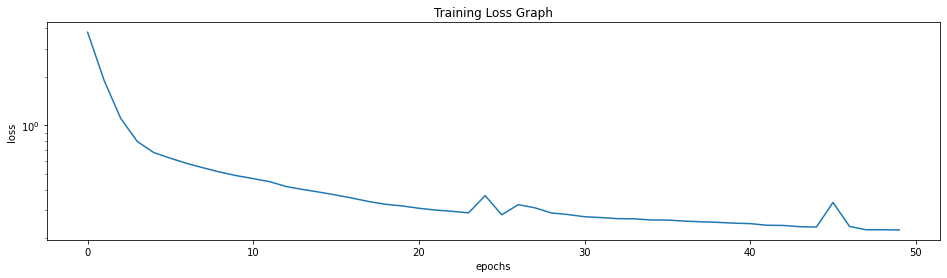

In [43]:
# check loss
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(LOSS_HISTORY)
plt.show()

## Validation

In [44]:
# load model
with open("/content/new_gru.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])

<All keys matched successfully>

In [58]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            # dist.append(np.mean(torch.abs(answer - guess).cpu().numpy(), axis = 1)) #autoencoder
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 6 * piece))
    # plt.ylim(0.01, 0.1)
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        prev = label # added
        while True:
            if current > ts_label:
              ts_label, label = next(g_label)
              continue
            elif current < ts_label:
              if ts_label - current <= timedelta(seconds=2): #added. 2초 전이라면 0대신에 해당 라벨을 add.
                final_labels.append(label) # added
              else:
                final_labels.append(0)
              current = next(g_ts)
              continue
            final_labels.append(label)
            prev = label
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [46]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_VAL, MODEL, BATCH_SIZE)

CPU times: user 6.59 s, sys: 1.88 s, total: 8.48 s
Wall time: 8.49 s


In [47]:
CHECK_DIST.shape #(43112, 79)

(43152, 79)

In [48]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
ANOMALY_SCORE.shape #(43112,)

(43152,)

In [53]:
# def new_anomaly(dist):
#   prev = dist[0]
#   anomaly = []
#   for e in dist:
#     anomaly.append(np.abs(prev - e))
#     prev = e
#   return np.array(anomaly)

# ANOMALY_SCORE = new_anomaly(ANOMALY_SCORE)

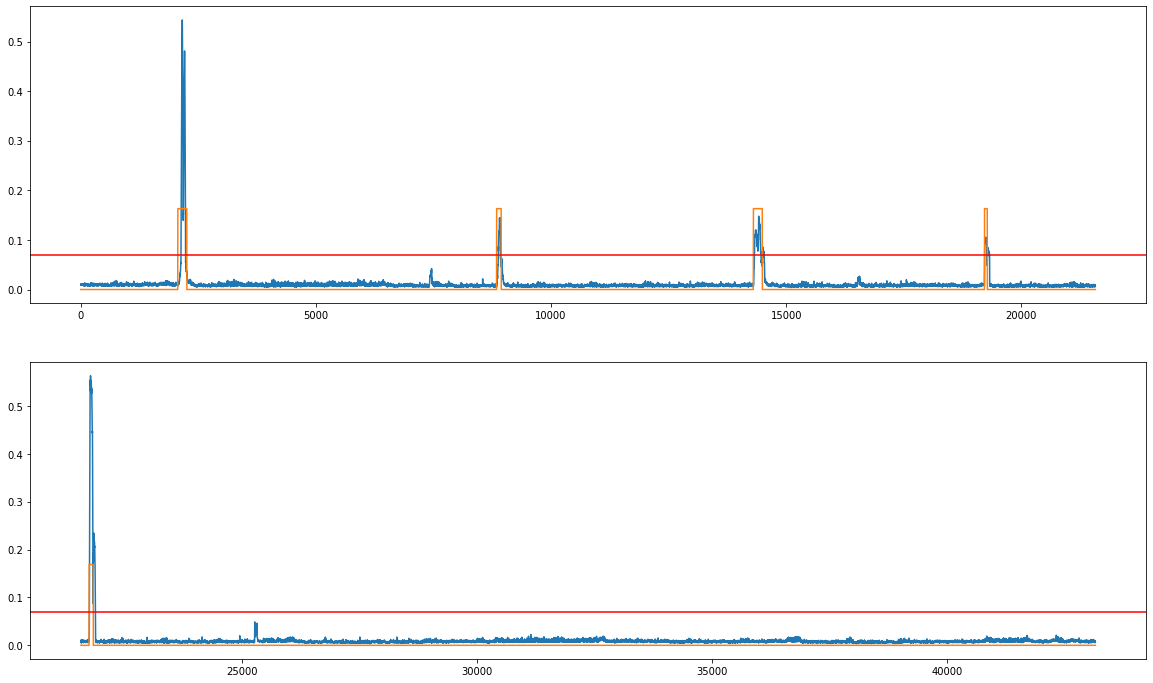

In [69]:
THRESHOLD = 0.07 # change
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

In [70]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
display(LABELS, LABELS.shape) #(43112,)
LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DATASET['time']))
print(LABELS.shape)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

(43152,)

(43201,)


In [60]:
ATTACK_LABELS = np.squeeze(np.array(VALIDATION_DATASET['attack']))
# ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), 0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (43201,))

In [61]:
ATTACK_LABELS.shape[0] == LABELS.shape[0]

True

### Get score

In [71]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.939 (TaP: 0.997, TaR: 0.888)
# of detected anomalies: 5
Detected anomalies: ['1', '2', '3', '4', '5']


## Test

In [72]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_TEST, MODEL, BATCH_SIZE)

CPU times: user 54.6 s, sys: 16 s, total: 1min 10s
Wall time: 1min 10s


In [73]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
ANOMALY_SCORE.shape

(358608,)

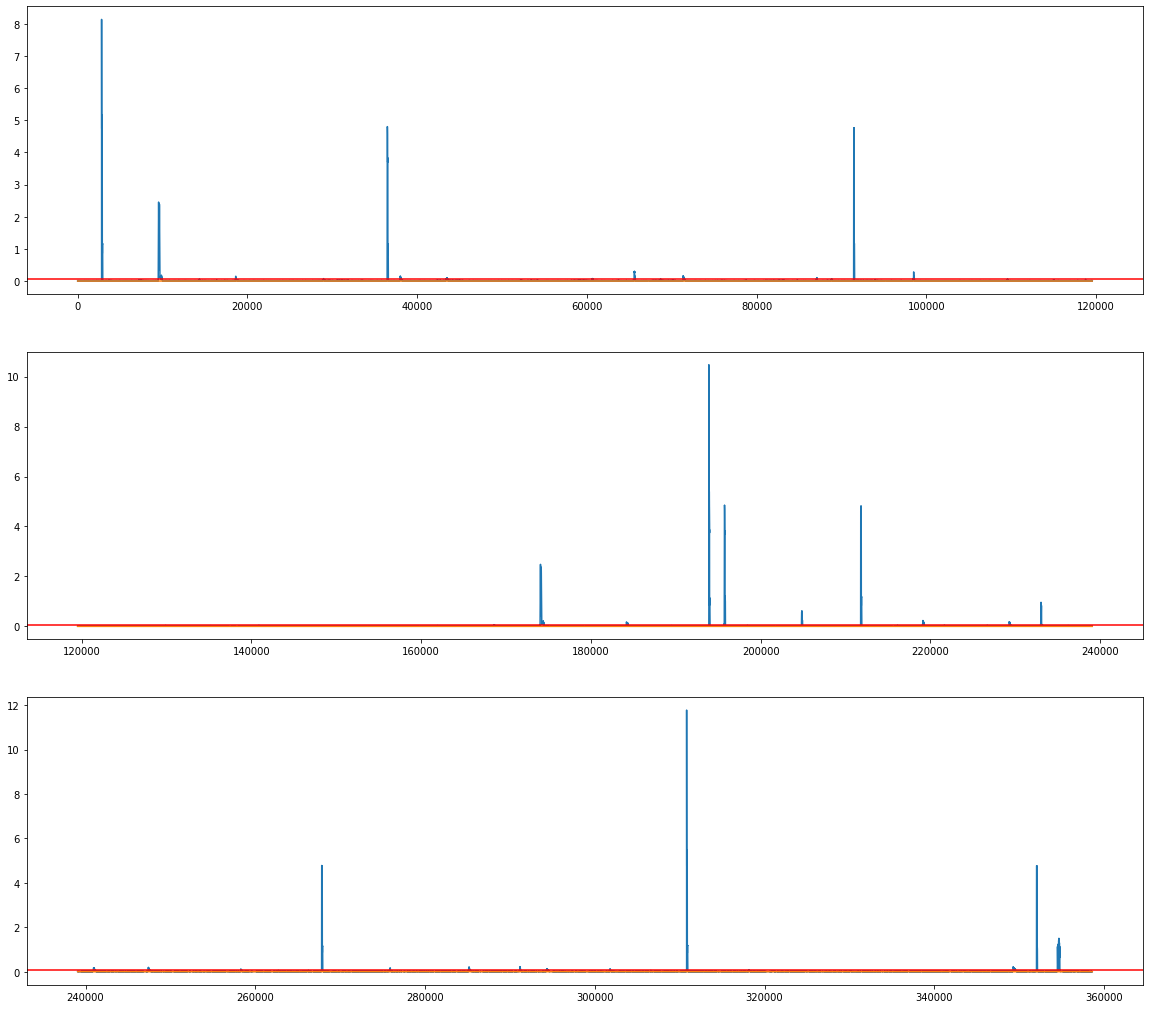

In [74]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

In [75]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (358608,))

In [76]:
submission = pd.read_csv(HOME + '/data/sample_submission.csv')
submission.index = submission['time']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,time,attack
time,,
2020-07-09 15:00:00,2020-07-09 15:00:00,0.0
2020-07-09 15:00:01,2020-07-09 15:00:01,0.0
2020-07-09 15:00:02,2020-07-09 15:00:02,0.0
2020-07-09 15:00:03,2020-07-09 15:00:03,0.0
2020-07-09 15:00:04,2020-07-09 15:00:04,0.0
...,...,...
2020-07-31 12:29:56,2020-07-31 12:29:56,0.0
2020-07-31 12:29:57,2020-07-31 12:29:57,0.0
2020-07-31 12:29:58,2020-07-31 12:29:58,0.0


In [77]:
submission.to_csv('new_gru.csv', index=False)